In [67]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [68]:
import numpy as np
import h5py
#from chainconsumer import ChainConsumer
from corner import corner

In [69]:
! ls -ltr /scratch/users/swmclau2/PearceMCMC/*.hdf5

-rw-r--r-- 1 swmclau2 kipac      12928 Jun  2 13:49 /scratch/users/swmclau2/PearceMCMC/HSAB_HOD_xi_gg_.hdf5
-rw-r--r-- 1 swmclau2 kipac  285400697 Jun  2 14:57 /scratch/users/swmclau2/PearceMCMC/HOD_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  328324673 Jun  2 14:57 /scratch/users/swmclau2/PearceMCMC/VpeakSHAM_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  325737318 Jun  2 14:57 /scratch/users/swmclau2/PearceMCMC/HOD_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  305678919 Jun  2 14:58 /scratch/users/swmclau2/PearceMCMC/VpeakSHAM_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  342139483 Jun  2 14:58 /scratch/users/swmclau2/PearceMCMC/MpeakSHAM_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  292621035 Jun  2 14:58 /scratch/users/swmclau2/PearceMCMC/HSAB_HOD_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  364872434 Jun  2 14:58 /scratch/users/swmclau2/PearceMCMC/MpeakSHAM_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 kipac  3274016

In [70]:
#fname = '/scratch/users/swmclau2/PearceMCMC/500_walkers_10000_steps_chain_cosmo_zheng_xi_lowmsat.npy'
fname = '/scratch/users/swmclau2/PearceMCMC/VpeakSHAM_xi_gg_rmin_None_CorrAB_fixed_cosmo.hdf5'

In [71]:
f = h5py.File(fname, 'r')

In [72]:
f.attrs.keys()

[u'emu_type',
 u'training_file',
 u'fixed_params',
 u'emu_hps',
 u'true_data_fname',
 u'true_cov_fname',
 u'sim',
 u'obs',
 u'cov',
 u'mcmc_type',
 u'nwalkers',
 u'nsteps',
 u'nlive',
 u'dlogz',
 u'nburn',
 u'seed',
 u'chain_fixed_params',
 u'param_names']

In [73]:
from ast import literal_eval

In [74]:
f.keys()

[u'chain', u'cov', u'data', u'evidence']

In [75]:
n_walkers = 1#f.attrs['nwalkers']

In [76]:
print n_walkers

1


In [77]:
f.keys()

[u'chain', u'cov', u'data', u'evidence']

In [78]:
sim_info = literal_eval(f.attrs['sim'])

In [79]:
n_burn = 500
n_samples = 1000
chain = f['chain'][n_burn*n_walkers:n_walkers*(n_samples+n_burn)]

In [80]:
chain = chain[np.all(chain!=0.0, axis = 1), :]

In [81]:
print chain.shape, chain.shape[0]/n_walkers

(501, 7) 501


In [82]:
gal_type = literal_eval(f.attrs['sim'])['gal_type']

In [83]:
chain_pnames = f.attrs['param_names']

In [84]:
chain_pnames

array(['mean_occupation_centrals_assembias_corr1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_corr1', 'logM1', 'alpha',
       'conc_gal_bias'], 
      dtype='|S42')

In [85]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'ln10As': r'$\ln(10A_s)$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$' }

In [86]:
hod_param_names = []
cosmo_param_names = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(param_name_dict[pname])
    else:
        hod_param_names.append(param_name_dict[pname])

In [87]:
f.close()

In [88]:
cosmo_param_names

[]

In [89]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [90]:
MAP = chain.mean(axis = 0)
print MAP

[ -0.11991227  13.10412025   0.25322688  -0.05981587  14.38122177
   0.9977957    1.26711845]


In [91]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)))
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [92]:
if chain.shape[1] == 7:
    cosmo_chain = chain
elif chain.shape[1] > 10:
    hod_chain = chain[:,hod_idxs]
    cosmo_chain = chain[:,cosmo_idxs]
else:
    hod_chain = chain

In [93]:
hod_chain = chain

In [94]:
if gal_type == 'HOD':
    from pearce.mocks import cat_dict
    cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
                    'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
                    'system': sim_info['sim_hps']['system']}
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}
    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    hod_params = sim_info['hod_params']
    hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    hod_true_vals.insert(0, 0)
    hod_true_vals.insert(3, 0)
    hod_true_vals.append(1.0)
    #hod_true_vals = [MAP[idx] for idx, key in enumerate(chain_pnames) if key in hod_params]
else: #SHAM
    #cosmo_true_vals = [3.7,70.7317,-1.13151,0.12283, 3.11395,  0.953515,  0.021762]
    #cosmo_true_vals = [0.046*0.7**2, (0.27-0.046)*0.7**2, -1, 0.95, 3.08511, 70, 3.04] 
    # multidark
    cosmo_true_vals = np.array([0.02214, 0.1175, -1, 0.9676, 3.0819, 0.6881*100, 3.04]) #darksky
    hod_true_vals = np.array([np.inf for p in hod_param_names])

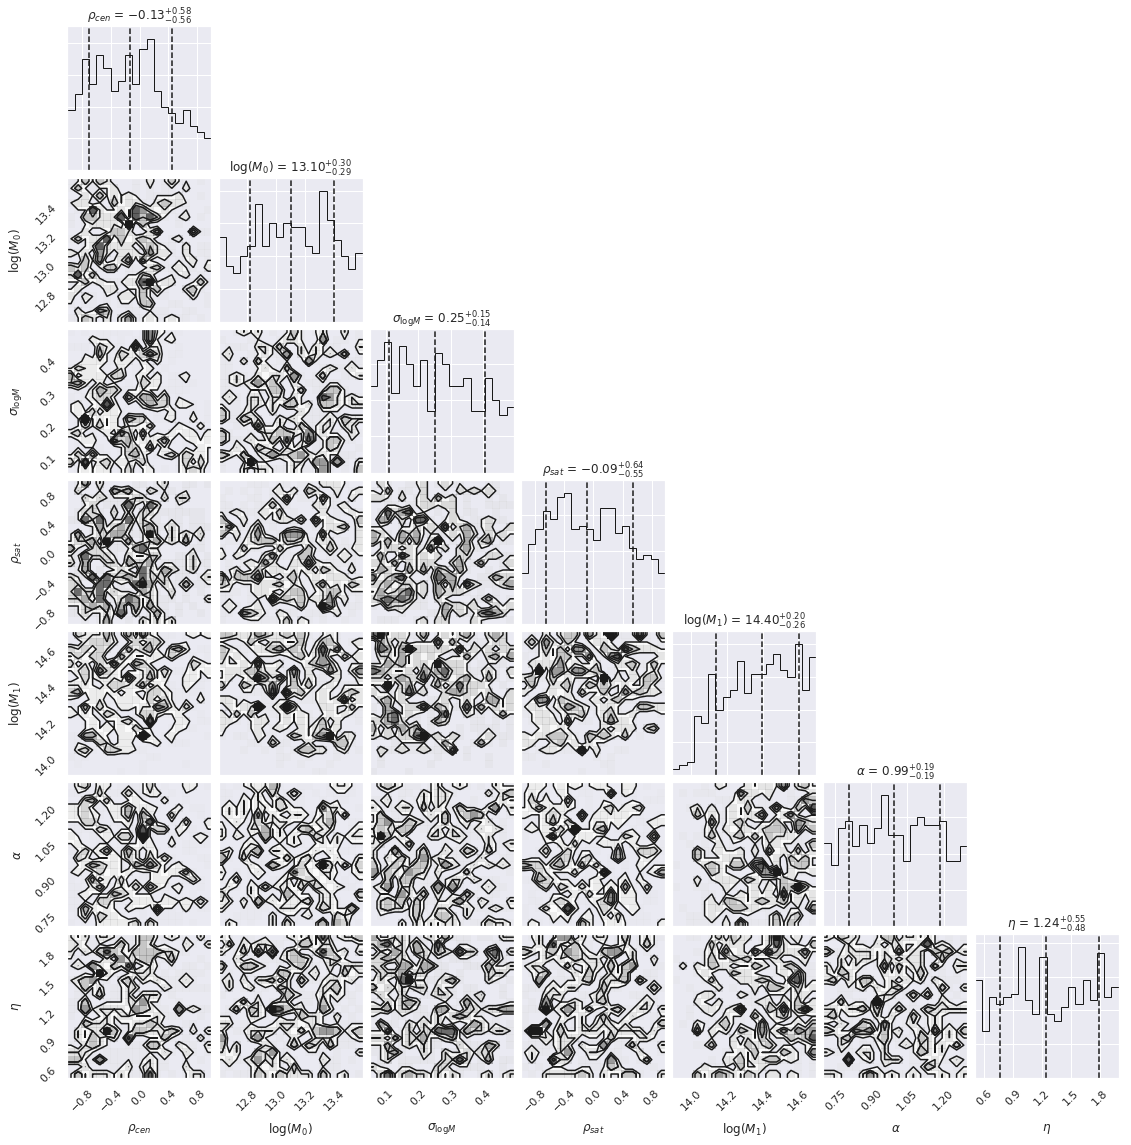

In [95]:
corner(hod_chain, labels=hod_param_names,
                       quantiles=[0.16, 0.5, 0.84],
                        truths = hod_true_vals,
                       #range = [emu.get_param_bounds(n) for n in hod_params],
                       show_titles=True, title_kwargs={"fontsize": 12},
                      plot_datapoints =False, plot_density = True);

IndexError: list index out of range

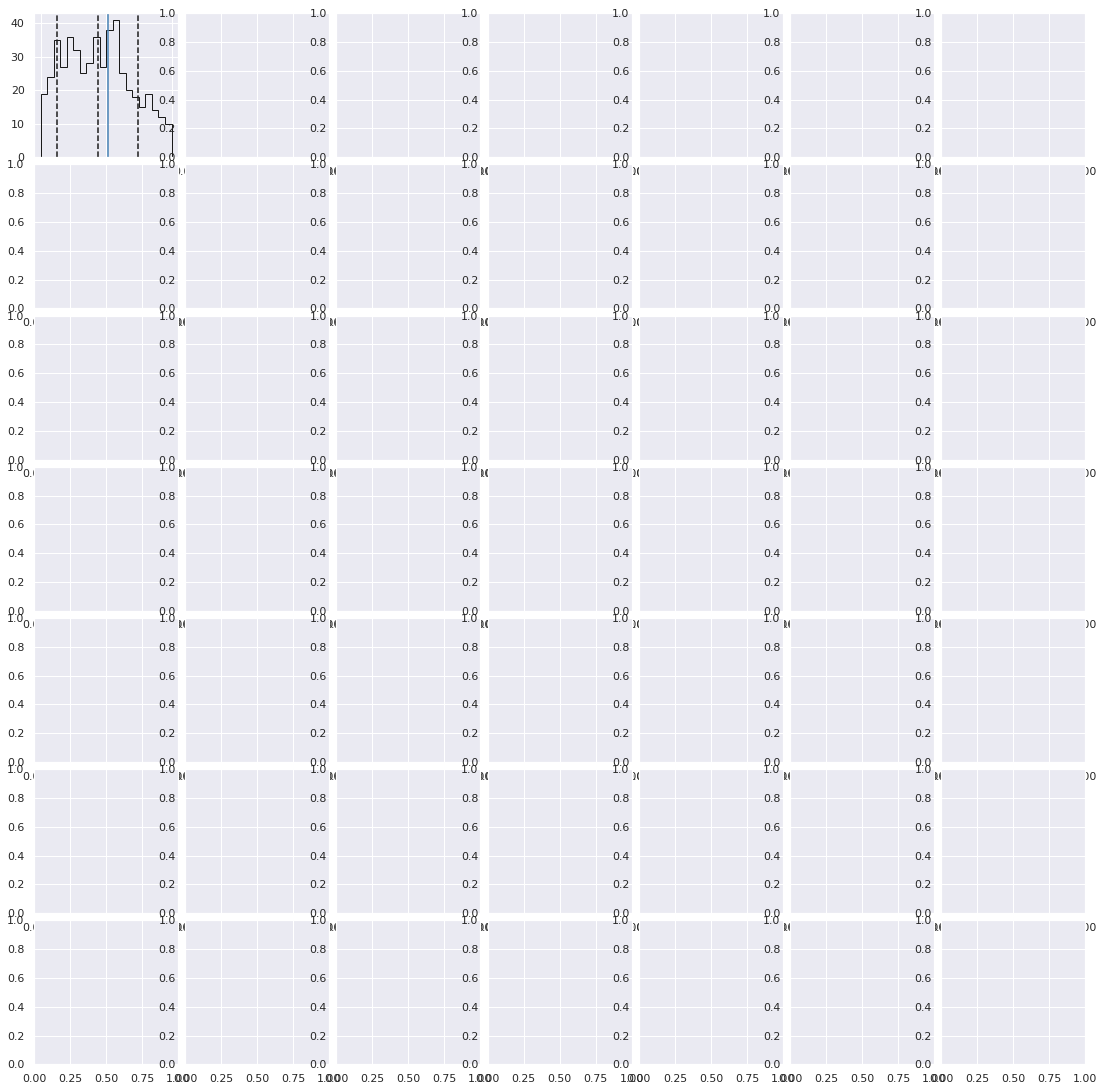

In [96]:
corner(cosmo_chain, labels=cosmo_param_names,
                       quantiles=[0.13, 0.5, 0.86],
                        truths = cosmo_true_vals,
                       show_titles=True, title_kwargs={"fontsize": 12},
                          plot_datapoints = False, plot_density = True);

In [ ]:
l = cosmo_param_names
l.extend(hod_param_names)
corner(chain, 
       labels = l,
       truths = np.hstack([cosmo_true_vals, hod_true_vals]),
    quantiles=[0.16, 0.5, 0.84], show_titles=True,title_kwargs={"fontsize": 12},
    plot_datapoints = False, plot_density = True);

In [ ]:
f.close()